# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 07**: Structured Streaming with Files

**Date**: October 10 2025

**Student Name**: Axel Leonardo Fernandez Albarran

**Professor**: Pablo Camarillo Ramirez

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/10 04:56:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Checamos que exista la carpeta donde el productor arrojara los csv

In [2]:
!pwd
!ls /opt/spark/work-dir/data/producer/

/opt/spark/work-dir


In [ ]:
from axel_fernandez.spark_utils import SparkUtils

log_schema = SparkUtils.get_logs_schema() # Creamos el esquema

# Leemos por batches los archivos CSV que se van generando
logs_df = spark.readStream \
    .format("csv") \
    .option("delimiter", "|") \
    .option("header", "false") \
    .schema(log_schema) \
    .load("/opt/spark/work-dir/data/producer/")

# Muestra los resultados en consola
query = logs_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", "false") \
    .queryName("AllLogs") \
    .start()

query.awaitTermination(60)  # Espera 60 segundos

-------------------------------------------
Batch: 0
-------------------------------------------
+-------------------+---------+--------------------------------+-------------+
|timestamp          |log_level|description                     |server       |
+-------------------+---------+--------------------------------+-------------+
|2025-10-09 22:58:11|ERROR    |Invalid authentication token    |server-node-4|
|2025-10-09 22:58:11|WARN     |Connection pool nearing capacity|server-node-2|
|2025-10-09 22:58:11|ERROR    |Data validation failed          |server-node-4|
|2025-10-09 22:58:11|ERROR    |Service unavailable             |server-node-2|
|2025-10-09 22:58:11|WARN     |Connection pool nearing capacity|server-node-2|
|2025-10-09 22:58:11|WARN     |Deprecated API used             |server-node-1|
|2025-10-09 22:58:11|INFO     |Data synchronized               |server-node-4|
|2025-10-09 22:58:11|CRITICAL |Cluster quorum lost             |server-node-1|
|2025-10-09 22:58:11|INFO     |API

False

# Log generator en accion
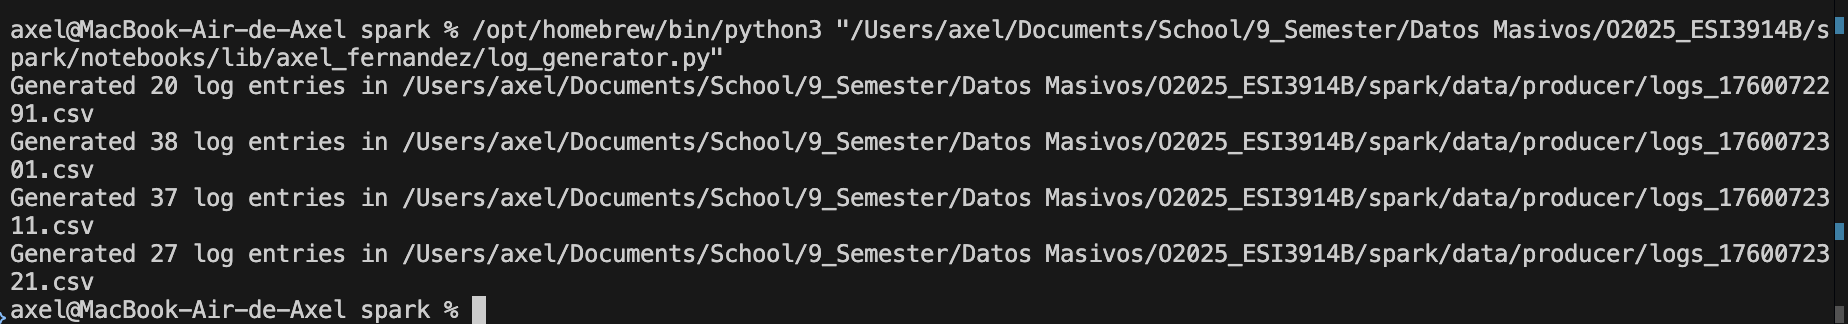

# Volvemos a leer los archivos pero ahora filtramos solamente la cantidad de registros que tengan error.

In [5]:
from pyspark.sql.functions import col

if 'query' in locals():
    query.stop()

# Leemos por batches los archivos CSV que se van generando
logs_df2 = spark.readStream \
    .format("csv") \
    .option("delimiter", "|") \
    .option("header", "false") \
    .schema(log_schema) \
    .load("/opt/spark/work-dir/data/producer/")

# Filtramos solo los registros con ERROR
error_logs = logs_df2.filter(col("log_level") == "ERROR")

# Muestra los resultados en consola
query2 = error_logs.writeStream \
    .outputMode("append") \
    .format("console") \
    .option("truncate", "false") \
    .queryName("ErrorLogs") \
    .start()

query2.awaitTermination(60)  # Espera 60 segundos

-------------------------------------------
Batch: 0
-------------------------------------------
+-------------------+---------+-------------------------+-------------+
|timestamp          |log_level|description              |server       |
+-------------------+---------+-------------------------+-------------+
|2025-10-09 23:03:58|ERROR    |500 Internal Server Error|server-node-1|
|2025-10-09 23:03:58|ERROR    |Network timeout          |server-node-4|
|2025-10-09 23:03:58|ERROR    |Service unavailable      |server-node-2|
+-------------------+---------+-------------------------+-------------+

-------------------------------------------
Batch: 5
-------------------------------------------
+-------------------+---------+-------------------------+-------------+
|timestamp          |log_level|description              |server       |
+-------------------+---------+-------------------------+-------------+
|2025-10-09 23:03:58|ERROR    |500 Internal Server Error|server-node-1|
|2025-10-09 2

False